# Monoculture Logistic Growth Fit
This notebook performs a clean logistic growth fit on the two untreated monoculture datasets.

What you get:
- Data loading and preprocessing (day extraction and averaging)
- Logistic ODE fit with parameter bounds
- Sum of Squared Residuals (SSR) and Bayesian Information Criterion (BIC)
- Plot of data with fitted model curve and a concise parameter report

> Notes:
- Uses CSV, DataFrames, DifferentialEquations, Optimization, and BlackBoxOptim.
- If packages are missing, add them in your Julia REPL: Pkg.add("CSV"), etc.

In [43]:
# 1) Packages
using Pkg
pkgs = [
    "CSV", "DataFrames", "Statistics",
    "DifferentialEquations", "DiffEqParamEstim",
    "Optimization", "OptimizationOptimJL",
    "BlackBoxOptim", "Plots", "Glob"
 ]
for p in pkgs
    try
        Base.eval(Main, :(import $(Symbol(p))))
    catch
        Pkg.add(p)
        Base.eval(Main, :(import $(Symbol(p))))
    end
end
println("✔ Packages ready: ", join(pkgs, ", "))

✔ Packages ready: CSV, DataFrames, Statistics, DifferentialEquations, DiffEqParamEstim, Optimization, OptimizationOptimJL, BlackBoxOptim, Plots, Glob


In [44]:
# 2) Using imports
using CSV, DataFrames, Statistics
using DifferentialEquations
using DiffEqParamEstim
using Optimization, OptimizationOptimJL
using BlackBoxOptim
using Plots
using Printf
using Glob

In [45]:
# 3) Models
function logistic!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1]/K)
end

logistic! (generic function with 1 method)

In [ ]:
# 4) Main functions (fast path; CSVs already contain day averages)
struct FitResult
    r::Float64
    K::Float64
    SSR::Float64
    BIC::Float64
end

# Helper: find a column by fuzzy name (case-insensitive substring match)
function _find_col(df::DataFrame; must_include::Vector{String}=[])
    for c in names(df)
        s = lowercase(String(c))
        ok = all(substr -> occursin(substr, s), must_include)
        ok && return Symbol(c)
    end
    return nothing
end

# Collapse duplicate x values by mean of y
function dedupe_xy(x::Vector{Float64}, y::Vector{Float64})
    df = DataFrame(day=x, value=y)
    g = combine(groupby(df, :day), :value => mean => :value)
    return Float64.(g.day), Float64.(g.value)
end

# Read pre-averaged data: prefer Cells-based headers (backward-compatible)
function load_monoculture_csv(path::AbstractString; scale_if_area::Float64=1.0)
    df = CSV.read(path, DataFrame)
    # Detect the day column
    daycol = nothing
    if :day ∈ names(df)
        daycol = :day
    elseif :Day ∈ names(df)
        daycol = :Day
    else
        # any column whose name contains "day"
        daycol = _find_col(df; must_include=["day"])
    end
    daycol === nothing && error("Could not find a 'day' column in $(basename(path))")

    # Detect value column (prefer Cells)
    preferred_exact = (
        :Cells, Symbol("Mean Cells"), Symbol("Average_Cells"), Symbol("Mean_Cells")
    )
    valcol = nothing
    for cand in preferred_exact
        if cand ∈ names(df)
            valcol = cand
            break
        end
    end
    if valcol === nothing
        # fuzzy search prioritizing 'cells'
        valcol = _find_col(df; must_include=["cells"])  # e.g., "mean cells"
    end
    if valcol === nothing
        # legacy: mean area columns or raw area
        valcol = _find_col(df; must_include=["mean","area"])  # e.g., "Mean Area µm^2"
        if valcol === nothing && Symbol("Area µm^2") ∈ names(df)
            valcol = Symbol("Area µm^2")
        end
    end
    valcol === nothing && error("No suitable value column found in $(basename(path)). Looked for Cells/Mean Cells/Area.")

    x = Float64.(df[!, daycol])
    y = Float64.(df[!, valcol])

    # Only scale if it's clearly an area column
    valname = lowercase(String(valcol))
    if occursin("area", valname) && scale_if_area != 1.0
        y ./= scale_if_area
    end

    # Sort and dedupe identical days by averaging y
    perm = sortperm(x)
    x = x[perm]; y = y[perm]
    return dedupe_xy(x, y)
end

# Specialized loader for day-average CSVs: returns (x, y, yerr)
function load_day_averages(path::AbstractString)
    df = CSV.read(path, DataFrame)
    # day column
    daycol = if :Day ∈ names(df)
        :Day
    else
        _find_col(df; must_include=["day"]) |> x -> x === nothing ? error("No Day column in $(basename(path))") : x
    end
    # mean value column (Cells)
    valcol = if Symbol("Mean Cells") ∈ names(df)
        Symbol("Mean Cells")
    elseif Symbol("Mean_Cells") ∈ names(df)
        Symbol("Mean_Cells")
    else
        _find_col(df; must_include=["mean","cells"]) |> x -> x === nothing ? error("No mean cells column in $(basename(path))") : x
    end
    # error column: prefer SEM, fallback to SD
    errcol = if Symbol("SEM Cells") ∈ names(df)
        Symbol("SEM Cells")
    elseif Symbol("Std_Error_Cells") ∈ names(df)
        Symbol("Std_Error_Cells")
    elseif Symbol("SD Cells") ∈ names(df)
        Symbol("SD Cells")
    elseif Symbol("Std_Dev_Cells") ∈ names(df)
        Symbol("Std_Dev_Cells")
    else
        nothing
    end
    x = Float64.(df[!, daycol])
    y = Float64.(df[!, valcol])
    yerr = isnothing(errcol) ? nothing : Float64.(df[!, errcol])
    # sort by day
    perm = sortperm(x)
    x = x[perm]; y = y[perm]; yerr = isnothing(yerr) ? nothing : yerr[perm]
    return x, y, yerr
end

# Helper to infer seeding density (e.g., "20k" or "30k") from a file path
function infer_density(path::AbstractString)
    for part in reverse(splitpath(String(path)))
        lp = lowercase(part)
        if lp == "20k" || lp == "30k"
            return part
        end
    end
    return ""
end

# Fit logistic and compute SSR + BIC (adaptive bounds)
function fit_logistic(x::Vector{<:Real}, y::Vector{<:Real}; r_bounds::Tuple{Float64,Float64}=(0.0, 2.0), K_bounds::Union{Nothing,Tuple{Float64,Float64}}=nothing)
    x = collect(Float64.(x)); y = collect(Float64.(y))
    tspan = (x[1], x[end])
    u0 = [max(y[1], eps())]
    # Adaptive K upper bound near ~2-5x max observed
    ymax = maximum(y)
    k_hi = isnothing(K_bounds) ? max(100.0, 5*ymax) : K_bounds[2]
    k_lo = isnothing(K_bounds) ? max(ymax/10, 1.0) : K_bounds[1]
    bounds = [r_bounds, (k_lo, k_hi)]
    best_p, best_sol, best_loss = nothing, nothing, Inf
    solver = Rosenbrock23()
    for _ in 1:10
        p0 = [rand(Uniform(r_bounds...)), rand(Uniform(bounds[2]...))]
        prob = ODEProblem(logistic!, u0, tspan, p0)
        obj = build_loss_objective(prob, solver, L2Loss(x, y), Optimization.AutoForwardDiff())
        res = bboptimize(obj; SearchRange=bounds, MaxTime=20.0, TraceMode=:silent)
        p̂ = best_candidate(res)
        sol̂ = solve(remake(prob, p=p̂), solver; saveat=x, reltol=1e-9, abstol=1e-9)
        pred = getindex.(sol̂.u, 1)
        if length(pred) != length(y)
            # Safety: re-solve if mismatch
            sol̂ = solve(remake(prob, p=p̂), solver; saveat=x)
            pred = getindex.(sol̂.u, 1)
        end
        loss = sum(abs2.(y .- pred))
        if loss < best_loss
            best_p, best_sol, best_loss = p̂, sol̂, loss
        end
    end
    n = length(y); k = 2
    ssr = best_loss
    bic = n > k ? n*log(ssr/n) + k*log(n) : NaN
    return best_p, best_sol, FitResult(best_p[1], best_p[2], ssr, bic)
end

function plot_data_and_fit(x, y, sol; title_str="Logistic Fit", yerr=nothing)
    if yerr === nothing
        plt = scatter(x, y; label="Data", xlabel="Day", ylabel="Cells", title=title_str)
    else
        plt = scatter(x, y; yerror=yerr, label="Data ± error", xlabel="Day", ylabel="Cells", title=title_str)
    end
    plot!(plt, sol.t, getindex.(sol.u,1); label="Model", lw=2)
    display(plt)
end

plot_data_and_fit (generic function with 1 method)

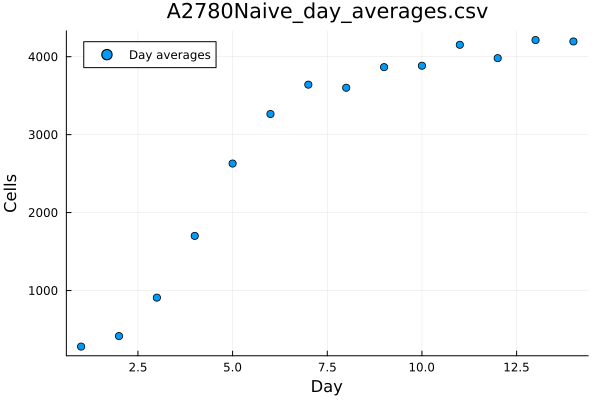

In [ ]:
# 5) Data plot (single CSV quick check — day averages only with error bars)
# Use processed day-average file provided
naive_csv = joinpath(pwd(), "Processed_Datasets", "Untreated MonoCulture", "20k", "Averages", "A2780Naive_day_averages.csv")
x_demo, y_demo, yerr_demo = load_day_averages(naive_csv)
density_demo = infer_density(naive_csv)
scatter(x_demo, y_demo; yerror=yerr_demo, xlabel="Day", ylabel="Cells", title=(density_demo=="" ? "" : density_demo*" • ") * basename(naive_csv), label="Day averages")

Demo Fit — r = 0.770405, K = 4068.59
SSR = 204070.0740
BIC = 139.498


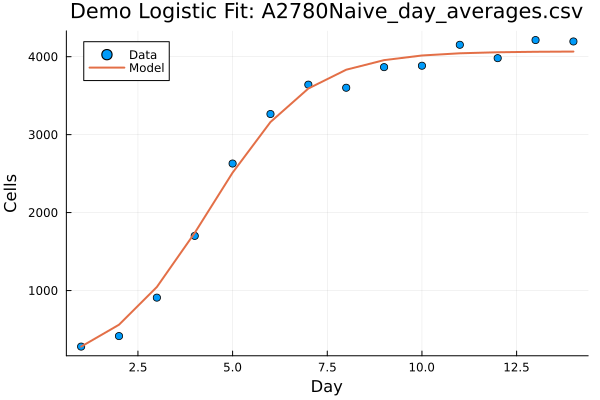

In [ ]:
# 6) Main run cell (fit + plot for the demo CSV)
# Fit on day averages only
p̂_demo, sol_demo, fr_demo = fit_logistic(x_demo, y_demo)
@printf("Demo Fit — r = %.6f, K = %.2f\n", fr_demo.r, fr_demo.K)
@printf("SSR = %.4f\n", fr_demo.SSR)
@printf("BIC = %.3f\n", fr_demo.BIC)
plot_data_and_fit(x_demo, y_demo, sol_demo; title_str=(density_demo=="" ? "" : density_demo*" • ") * ("Demo Logistic Fit: " * basename(naive_csv)), yerr=yerr_demo)

Resistant Fit — r = 0.715480, K = 3914.90
SSR = 804850.7283
BIC = 178.758


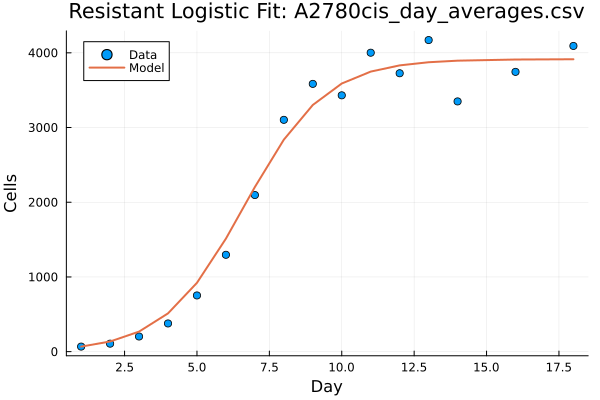


Summary:
Naive:  r=0.770405, K=4068.59, SSR=204070.0740, BIC=139.498
Resist: r=0.715480, K=3914.90, SSR=804850.7283, BIC=178.758


In [ ]:
# 7) Optional: Fit the other untreated monoculture CSV (day averages only)
resist_csv = joinpath(pwd(), "Processed_Datasets", "Untreated MonoCulture", "20k", "Averages", "A2780cis_day_averages.csv")
x_r, y_r, yerr_r = load_day_averages(resist_csv)
density_r = infer_density(resist_csv)
p̂_r, sol_r, fr_r = fit_logistic(x_r, y_r)
@printf("Resistant Fit — r = %.6f, K = %.2f\n", fr_r.r, fr_r.K)
@printf("SSR = %.4f\n", fr_r.SSR)
@printf("BIC = %.3f\n", fr_r.BIC)
plot_data_and_fit(x_r, y_r, sol_r; title_str=(density_r=="" ? "" : density_r*" • ") * ("Resistant Logistic Fit: " * basename(resist_csv)), yerr=yerr_r)
println("\nSummary:")
@printf("Naive:  r=%.6f, K=%.2f, SSR=%.4f, BIC=%.3f\n", fr_demo.r, fr_demo.K, fr_demo.SSR, fr_demo.BIC)
@printf("Resist: r=%.6f, K=%.2f, SSR=%.4f, BIC=%.3f\n", fr_r.r, fr_r.K, fr_r.SSR, fr_r.BIC)

In [ ]:
# 8) Batch run for Untreated MonoCulture day averages only (20k and 30k) with error bars + per-file plots
# Collect only *_day_averages.csv under either 20k or 30k Averages folders
roots = [
    joinpath(pwd(), "Processed_Datasets", "Untreated MonoCulture", "20k", "Averages"),
    joinpath(pwd(), "Processed_Datasets", "Untreated MonoCulture", "30k", "Averages"),
]
files = String[]
for r in roots
    if isdir(r)
        for f in readdir(r; join=true)
            if endswith(lowercase(f), "_day_averages.csv")
                push!(files, f)
            end
        end
    end
end

if isempty(files)
    @warn "No day averages CSVs found under Untreated MonoCulture"
else
    println("Found ", length(files), " day-average files.")
end

results = DataFrame(File=String[], Density=String[], r=Float64[], K=Float64[], SSR=Float64[], BIC=Float64[])
for f in files
    try
        x, y, yerr = load_day_averages(f)
        _, sol, fr = fit_logistic(x, y)
        den = infer_density(f)
        push!(results, (basename(f), den, fr.r, fr.K, fr.SSR, fr.BIC))
        # Show per-file plot with error bars and density in title
        title_str = (den=="" ? "" : den*" • ") * ("Logistic Fit: " * basename(f))
        plot_data_and_fit(x, y, sol; title_str=title_str, yerr=yerr)
    catch e
        @warn "Failed on $(basename(f)): $e"
    end
end
println(results)

Found 4 day-average files.
